In [53]:
import signac
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import gsd.hoomd
from sklearn import preprocessing
from fitter import Fitter
from cmeutils.structure import gsd_rdf

In [3]:
# load project to get rigid simulations
project = signac.get_project()
jobs = list(project.find_jobs())
len(jobs)

8

In [4]:
kT_range = [job.sp.kT for job in jobs]
kT_range.sort()
kT_range

[0.1, 0.5, 0.75, 1.0, 2.0, 4.0, 6.0, 7.0]

In [5]:
for kT in kT_range:
    job = list(project.find_jobs(filter={'kT': kT}))[0]
    traj = gsd.hoomd.open(job.fn("trajectory.gsd"))
    print(f"kT: {kT} - {len(traj)}")

kT: 0.1 - 5101
kT: 0.5 - 25101
kT: 0.75 - 25101
kT: 1.0 - 25101
kT: 2.0 - 25101
kT: 4.0 - 10101
kT: 6.0 - 5101
kT: 7.0 - 5101


In [54]:
color = cm.rainbow(np.linspace(0, 1, len(kT_range)))

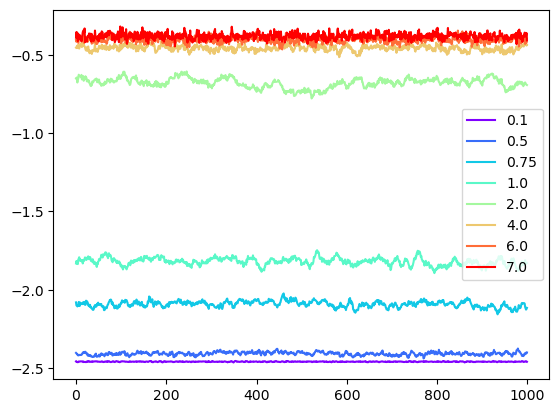

In [55]:
for i, kT in enumerate(kT_range):
    job = list(project.find_jobs(filter={'kT': kT}))[0]
    log = np.genfromtxt(job.fn("log.txt"), names=True)
    potential_energy = log['mdcomputeThermodynamicQuantitiespotential_energy'][-1000:] / (300*7)
    plt.plot(potential_energy, label=kT, c=color[i])
plt.legend()

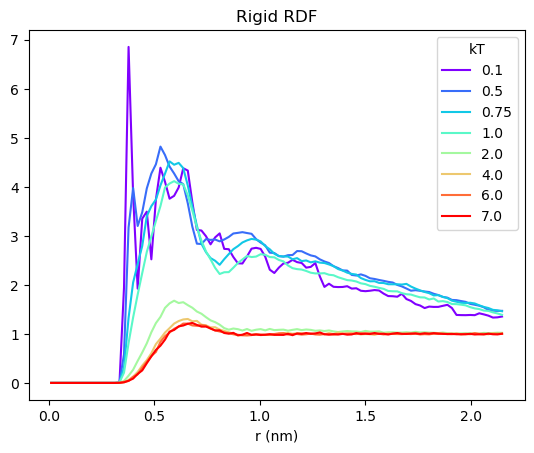

In [56]:
idx = -100
for i, kT in enumerate(kT_range):
    job = list(project.find_jobs(filter={'kT': kT}))[0]
    traj_gsd = job.fn("trajectory.gsd")
    rdf, rdf_norm = gsd_rdf(gsdfile=traj_gsd, A_name="rigid", B_name="rigid",r_max=6, start=idx, stop=-1)
    plt.plot(rdf.bin_centers * 0.36, rdf.rdf * rdf_norm, label=kT, c=color[i])
plt.legend(title="kT", bbox_to_anchor=(1., 1.))
plt.xlabel("r (nm)")
plt.title("Rigid RDF")
plt.savefig("Rigid_RDF.png")

## Gather all frames from trajectories

In [8]:
all_frames = []
for kT in kT_range:
    job = list(project.find_jobs(filter={'kT': kT}))[0]
    traj = gsd.hoomd.open(job.fn("trajectory.gsd"))
    for frame in traj[-4000:]:
        all_frames.append(frame)

In [9]:
len(all_frames)

32000

In [10]:
zero_energy_frames = []
for i, f in enumerate(all_frames):
    if f.log['md/compute/ThermodynamicQuantities/potential_energy'][0] == 0:
        zero_energy_frames.append(i)
len(zero_energy_frames)

0

In [11]:
forces = []
torques = []
N_rigid=300
for frame in all_frames:
    forces.append(frame.log['particles/md/constrain/Rigid/forces'][:N_rigid])
    torques.append(frame.log['particles/md/constrain/Rigid/torques'][:N_rigid])
forces = np.asarray(forces)   
torques = np.asarray(torques)

## check force distribution

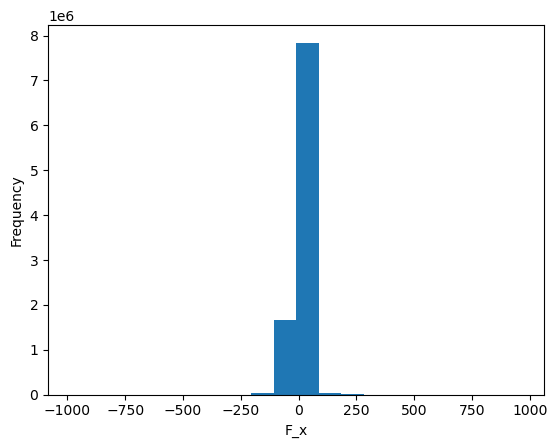

In [15]:
f_x = forces[:, :, 0].reshape(-1, 1).squeeze()
plt.hist(f_x, bins=20)

plt.xlabel('F_x')
plt.ylabel('Frequency')
plt.show()

/tmp/ipykernel_599931/861541673.py:1: RuntimeWarning: divide by zero encountered in log
  f_x = np.log(forces[:, :, 0].reshape(-1, 1).squeeze())
/tmp/ipykernel_599931/861541673.py:1: RuntimeWarning: invalid value encountered in log
  f_x = np.log(forces[:, :, 0].reshape(-1, 1).squeeze())


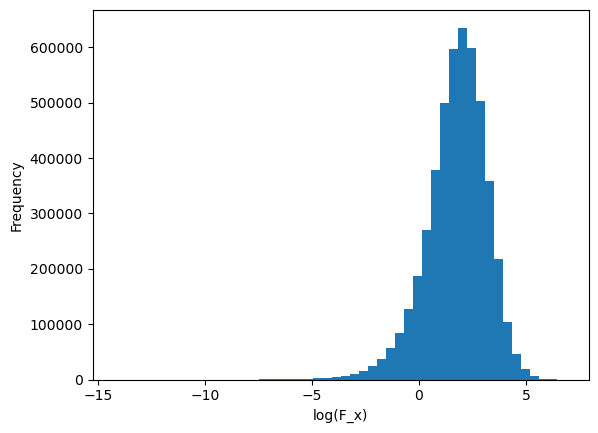

In [16]:
f_x = np.log(forces[:, :, 0].reshape(-1, 1).squeeze())
f_x[np.where(f_x == -np.inf)[0]] = 0
plt.hist(f_x, bins=50)

plt.xlabel('log(F_x)')
plt.ylabel('Frequency')
plt.show()

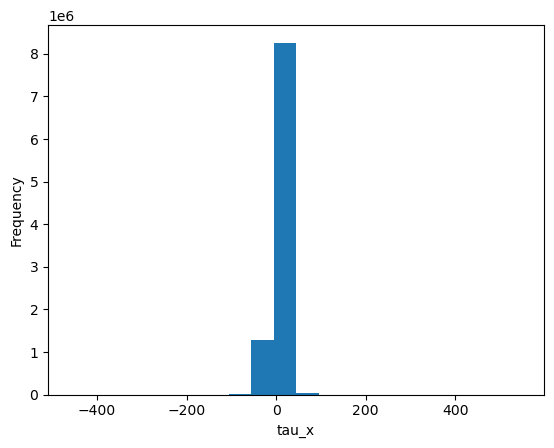

In [113]:

tau_x = np.asarray(torques)[:, :, 0].reshape(-1, 1).squeeze()
plt.hist(tau_x, bins=20)

plt.xlabel('tau_x')
plt.ylabel('Frequency')
plt.show()

## Preprocessing

In [114]:
force_data = forces.reshape(-1, 3)
print(f'Mean: {force_data.mean(axis=0)}')
print(f'std: {force_data.std(axis=0)}')
print(f'Max: {force_data.max(axis=0)}')
print(f'Min: {force_data.min(axis=0)}')


torque_data = np.asarray(torques).reshape(-1, 3)
print(f'Mean: {force_data.mean(axis=0)}')
print(f'std: {force_data.std(axis=0)}')
print(f'Max: {force_data.max(axis=0)}')
print(f'Min: {force_data.min(axis=0)}')

AttributeError: 'list' object has no attribute 'reshape'

### Solution 1: Standardize force

In [34]:
scaler = preprocessing.StandardScaler().fit(force_data)
force_scaled = scaler.transform(force_data)
print(f'Mean: {force_scaled.mean(axis=0)}')
print(f'std: {force_scaled.std(axis=0)}')
print(f'Max: {force_scaled.max(axis=0)}')
print(f'Min: {force_scaled.min(axis=0)}')

Mean: [-1.42208294e-19  4.62592927e-21 -5.10239998e-20]
std: [1. 1. 1.]
Max: [40.58015263 36.83780878 38.95635489]
Min: [-41.45216596 -36.45872081 -38.79538438]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
norm,0.169626,56278.700905,-5.457613e+08,inf,0.153978,0.0


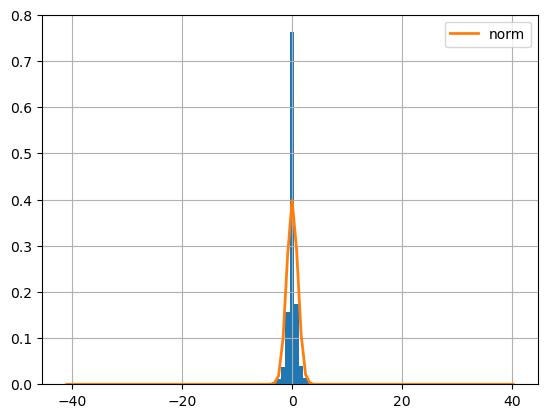

In [28]:
f = Fitter(force_scaled,
           distributions=["norm"])
f.fit()

f.summary()

## Solution 2: MinMaxScalar force

In [38]:
minmax_scaler = preprocessing.MinMaxScaler(feature_range=(-5, 5)).fit(force_data)
force_minmax_scaled = minmax_scaler.transform(force_data)
print(f'Mean: {force_minmax_scaled.mean(axis=0)}')
print(f'std: {force_minmax_scaled.std(axis=0)}')
print(f'Max: {force_minmax_scaled.max(axis=0)}')
print(f'Min: {force_minmax_scaled.min(axis=0)}')

Mean: [ 0.0531506  -0.02585989 -0.01035157]
std: [0.12190317 0.13643211 0.12861449]
Max: [5. 5. 5.]
Min: [-5. -5. -5.]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
norm,4.020756,46491.285961,-4.545911e+08,inf,0.133554,0.0


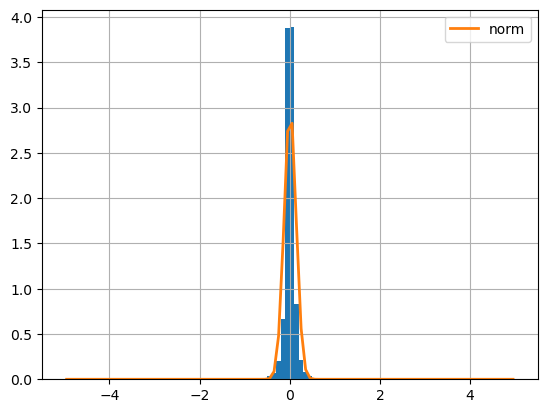

In [39]:
f = Fitter(force_minmax_scaled,
           distributions=["norm"])
f.fit()

f.summary()

## Solution 3: QuantileTransformer

In [42]:
quantile_transformer = preprocessing.QuantileTransformer(random_state=0, output_distribution='normal').fit(force_data)
force_quantile_transformed= quantile_transformer.transform(force_data)

print(f'Mean: {force_quantile_transformed.mean(axis=0)}')
print(f'std: {force_quantile_transformed.std(axis=0)}')
print(f'Max: {force_quantile_transformed.max(axis=0)}')
print(f'Min: {force_quantile_transformed.min(axis=0)}')

Mean: [ 0.00494162 -0.01375688  0.00633546]
std: [0.9943067  0.99994678 1.00013137]
Max: [5.19933758 5.19933758 5.19933758]
Min: [-5.19933758 -5.19933758 -5.19933758]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
norm,0.003297,1091.735407,-6.592479e+08,inf,0.004212,0.0


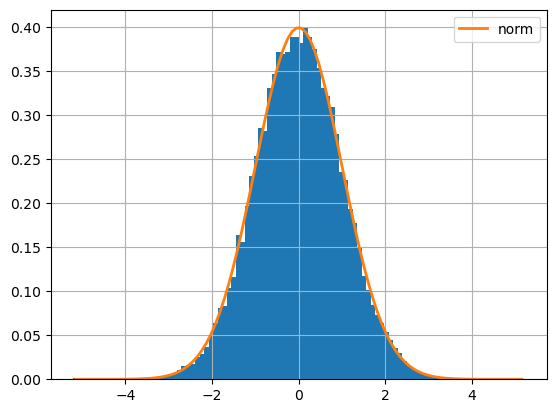

In [43]:
f = Fitter(force_quantile_transformed,
           distributions=["norm"])
f.fit()

f.summary()

## Solution 4: PowerTransformer

In [46]:
powertransformer = preprocessing.PowerTransformer(method='yeo-johnson', standardize=False).fit(force_data)
force_power_transformed = powertransformer.transform(force_data)
print(f'Mean: {force_power_transformed.mean(axis=0)}')
print(f'std: {force_power_transformed.std(axis=0)}')
print(f'Max: {force_power_transformed.max(axis=0)}')
print(f'Min: {force_power_transformed.min(axis=0)}')

Mean: [ 3.08025582e-06 -3.08515826e-03  6.21667626e-04]
std: [23.77623638 24.09083696 23.8157262 ]
Max: [964.84386549 886.95525459 927.88225054]
Min: [-985.57591787 -878.81397344 -923.83242054]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
norm,0.0003,56358.747195,-7.282914e+08,inf,0.154003,0.0


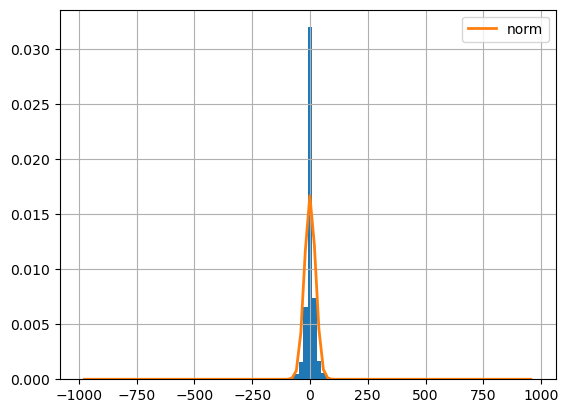

In [47]:
f = Fitter(force_power_transformed,
           distributions=["norm"])
f.fit()

f.summary()

### Create training dataset

In [104]:
import freud
def find_neighbors(points, L, NN=20):
    box = freud.box.Box.cube(L)
    aq = freud.locality.AABBQuery(box, points)

    query_points = points
    query_result = aq.query(query_points, dict(num_neighbors=NN, exclude_ii=True))
    nlist = query_result.toNeighborList()
    neighbor_list = np.asarray(list(zip(nlist.query_point_indices, nlist.point_indices)))
    return neighbor_list

## version 1: N_neighbors = 20

In [105]:
N_neighbors = 20

In [103]:
L = all_frames[-1].configuration.box[0]
L

15.769099

In [106]:
positions = []
neighbor_lists = []
orientations = []
forces = []
torques = []
energies = []
for i, frame in enumerate(all_frames):
    frame_positions = frame.particles.position[:N_rigid]
    neighbor_lists.append(find_neighbors(frame_positions,L=L, NN=N_neighbors))
    positions.append(frame_positions)
    orientations.append(frame.particles.orientation[:N_rigid])
    forces.append(frame.log['particles/md/constrain/Rigid/forces'][:N_rigid])
    torques.append(frame.log['particles/md/constrain/Rigid/torques'][:N_rigid])
    energies.append(frame.log['particles/md/constrain/Rigid/energies'][:N_rigid])
    if i % 1000 == 0:
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000


In [108]:
import rowan
orientations_R = rowan.to_matrix(orientations)
euler_angles = rowan.to_euler(orientations)

In [115]:
import pandas as pd
columns = [
    "position",
    "orientation_q",
    "orientation_R",
    "orientation_euler",
    "force",
    "torque",
    "energy",
    "neighbor_list"
]

new_traj_df = pd.DataFrame(columns=columns)
new_traj_df["position"] =positions
new_traj_df["orientation_q"] = orientations
new_traj_df["orientation_R"] = orientations_R.tolist()
new_traj_df["orientation_euler"] = euler_angles.tolist()
new_traj_df["force"] = forces
new_traj_df["torque"] = torques
new_traj_df["energy"] = energies
new_traj_df["neighbor_list"] = neighbor_lists

In [116]:
new_traj_df.head()

,position,orientation_q,orientation_R,orientation_euler,force,torque,energy,neighbor_list
0,"[[-6.0768604, -5.2041698, 6.475091], [-4.31740...","[[0.92165655, -0.26989144, -0.25946516, -0.101...","[[[0.8445843458175659, 0.32790711522102356, -0...","[[-0.05653252048726097, -0.5624789923973978, -...","[[7.411594734308556, 14.784282634549335, -1.97...","[[-4.438562438148194, -3.419781494160387, -3.2...","[-21.768709788728422, -21.158129515186104, -21...","[[0, 8], [0, 18], [0, 49], [0, 59], [0, 94], [..."
1,"[[-6.0962834, -5.1856084, 6.4809], [-4.338118,...","[[0.90870583, -0.26087165, -0.2828183, -0.1619...","[[[0.7876006364822388, 0.4418080449104309, -0....","[[-0.18414055471393956, -0.6415906126942512, -...","[[3.9643335342971966, -20.766395894445452, 3.3...","[[1.1189672226545018, 5.545636942573517, 6.330...","[-21.603110057477846, -21.53576566341523, -22....","[[0, 8], [0, 18], [0, 49], [0, 59], [0, 94], [..."
2,"[[-6.10226, -5.200979, 6.4890785], [-4.3258944...","[[0.9177464, -0.27194998, -0.26624328, -0.1135...","[[[0.8324305415153503, 0.35327544808387756, -0...","[[-0.07632154583075355, -0.5829162469322225, -...","[[3.8914802405986624, 14.765553448733435, -6.3...","[[2.0023199612034164, 1.2514003112377763, -7.3...","[-21.970008214458545, -21.409099700470755, -22...","[[0, 8], [0, 18], [0, 49], [0, 59], [0, 94], [..."
3,"[[-6.100011, -5.1927466, 6.4881463], [-4.31159...","[[0.9185614, -0.26475114, -0.25327304, -0.1483...","[[[0.8276964426040649, 0.4066261053085327, -0....","[[-0.16568864800959593, -0.5750057707753182, -...","[[-1.200543167781107, 2.0025238109007297, 4.46...","[[-2.486784669603247, -4.352114555110771, 2.70...","[-21.959829089989583, -21.285938481477775, -22...","[[0, 8], [0, 18], [0, 49], [0, 59], [0, 94], [..."
4,"[[-6.1014714, -5.1752267, 6.4932017], [-4.3070...","[[0.9148387, -0.26646665, -0.2561965, -0.16257...","[[[0.815868616104126, 0.4339863955974579, -0.3...","[[-0.19473226525082424, -0.5888390418141153, -...","[[-6.119066300491225, -4.326813217334056, -3.0...","[[-2.7352384723645593, 0.40252289782167217, 6....","[-22.180353913152747, -20.982513262329654, -22...","[[0, 8], [0, 18], [0, 49], [0, 59], [0, 94], [..."


In [118]:
new_traj_df = new_traj_df.sample(frac=1).reset_index(drop=True)# shuffle dataset

In [119]:
import os
target_datapath="/home/marjanalbooyeh/Aniso_ML_MD_project/ml_datasets/pps_300_N20"

new_traj_df.to_pickle(os.path.join(target_datapath, "raw.pkl"))
test_frac = 0.1
val_frac = 0.1

dataset_len = new_traj_df.shape[0]
test_len = int(dataset_len * test_frac)
val_len = int(dataset_len * val_frac)

test_df = new_traj_df.iloc[:test_len]

val_df = new_traj_df.iloc[test_len: test_len + val_len]

train_df = new_traj_df.iloc[test_len + val_len:]

In [120]:
train_df.to_pickle(os.path.join(target_datapath, 'train.pkl'))
val_df.to_pickle(os.path.join(target_datapath, 'val.pkl'))
test_df.to_pickle(os.path.join(target_datapath, 'test.pkl'))

In [121]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(25600, 8)
(3200, 8)
(3200, 8)


## version 2: Neighbiors = 50

In [122]:
N_neighbors = 50
L = all_frames[-1].configuration.box[0]

In [123]:
positions = []
neighbor_lists = []
orientations = []
forces = []
torques = []
energies = []
for i, frame in enumerate(all_frames):
    frame_positions = frame.particles.position[:N_rigid]
    neighbor_lists.append(find_neighbors(frame_positions,L=L, NN=N_neighbors))
    positions.append(frame_positions)
    orientations.append(frame.particles.orientation[:N_rigid])
    forces.append(frame.log['particles/md/constrain/Rigid/forces'][:N_rigid])
    torques.append(frame.log['particles/md/constrain/Rigid/torques'][:N_rigid])
    energies.append(frame.log['particles/md/constrain/Rigid/energies'][:N_rigid])
    if i % 1000 == 0:
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000


In [124]:
neighbor_lists[0].shape

(15000, 2)

In [125]:
orientations_R = rowan.to_matrix(orientations)
euler_angles = rowan.to_euler(orientations)

In [126]:
import pandas as pd
columns = [
    "position",
    "orientation_q",
    "orientation_R",
    "orientation_euler",
    "force",
    "torque",
    "energy",
    "neighbor_list"
]

new_traj_df = pd.DataFrame(columns=columns)
new_traj_df["position"] =positions
new_traj_df["orientation_q"] = orientations
new_traj_df["orientation_R"] = orientations_R.tolist()
new_traj_df["orientation_euler"] = euler_angles.tolist()
new_traj_df["force"] = forces
new_traj_df["torque"] = torques
new_traj_df["energy"] = energies
new_traj_df["neighbor_list"] = neighbor_lists

In [127]:
new_traj_df = new_traj_df.sample(frac=1).reset_index(drop=True)# shuffle dataset

In [128]:
import os
target_datapath="/home/marjanalbooyeh/Aniso_ML_MD_project/ml_datasets/pps_300_N50"

new_traj_df.to_pickle(os.path.join(target_datapath, "raw.pkl"))
test_frac = 0.1
val_frac = 0.1

dataset_len = new_traj_df.shape[0]
test_len = int(dataset_len * test_frac)
val_len = int(dataset_len * val_frac)

test_df = new_traj_df.iloc[:test_len]

val_df = new_traj_df.iloc[test_len: test_len + val_len]

train_df = new_traj_df.iloc[test_len + val_len:]

In [129]:
train_df.to_pickle(os.path.join(target_datapath, 'train.pkl'))
val_df.to_pickle(os.path.join(target_datapath, 'val.pkl'))
test_df.to_pickle(os.path.join(target_datapath, 'test.pkl'))